## Initial Setup

Let's start by importing some packages

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from keras.preprocessing.text import Tokenizer

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import string

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

Using TensorFlow backend.


## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 128 # Number of examples used in each iteration
    EPOCHS = 2 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40

MAX_LEN = 60 # Max length of review (in words)

## Data

The movie reviews dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

Let's take a look at data. The labels are encoded in the dataset: **0** is for *negative* and **1** for a *positive* review.

In [4]:
DS_PATH = '../data/telegram/' # ADD path/to/dataset
LABELS = ['negative', 'neutral', 'positive']

# Load data
data = pd.read_csv(os.path.join(DS_PATH, "in.csv"), sep=',', names=['user', 'time', 'text'])
data = data.dropna()

print("Data shape (rows, columns): ", data.shape)

Data shape (rows, columns):  (183009, 3)


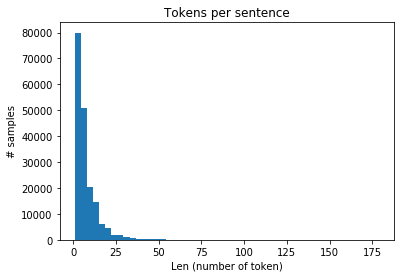

In [5]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in data['text'].values], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

AttributeError: 'Sequential' object has no attribute 'batch_size'

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the text. 

- We will use the Keras `Tokenizer` to convert each word to a corresponding integer ID. Representing words as integers saves a lot of memory!
- In order to feed the text into our CNN, all texts should be the same length. We ensure this using the `sequence.pad_sequences()` method and `MAX_LEN` variable. All texts longer than `MAX_LEN` are truncated and shorter texts are padded to get them to the same length.

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter. 

In [6]:
import pickle

tokenizer_path = './models/tokenizer.pickle'
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

x_seq = tokenizer.texts_to_sequences(data['text'].values)
x = sequence.pad_sequences(x_seq, maxlen=MAX_LEN, padding="post", value=0)


print('First sample before preprocessing: \n', data['text'].values[0], '\n')
print('First sample after preprocessing: \n', x[0])

First sample before preprocessing: 
 Welcome to 

First sample after preprocessing: 
 [393   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


## Model

We will implement a model similar to Kim Yoon’s [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

![cnn for text](https://github.com/floydhub/sentiment-analysis-template/raw/master/images/cnn.png)
*Image from [the paper](https://arxiv.org/abs/1408.5882)*

In [7]:
from keras.models import load_model
model = load_model('./models/cnn_sentiment.h5')

In [8]:
y_score = model.predict(x)

In [9]:
y_pred = np.ones(y_score.shape[0])

y_pred[y_score[:,0] > 0.65] = 0
y_pred[y_score[:,2] > 0.85] = 2

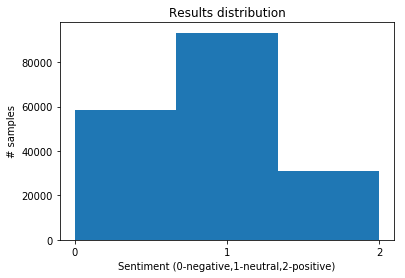

In [10]:
plt.hist(y_pred, bins=3)
plt.title('Results distribution')
plt.xlabel('Sentiment (0-negative,1-neutral,2-positive)')
plt.ylabel('# samples')
plt.xticks([0,1,2])
plt.show()

100%|██████████| 1000/1000 [00:02<00:00, 387.37it/s]


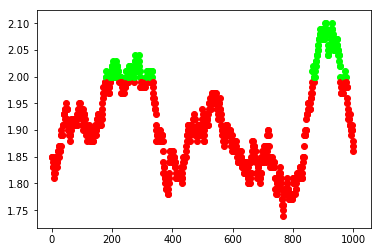

In [47]:
import tqdm
from scipy.signal import medfilt, medfilt

N = 100
# y_filt = medfilt(y_pred, kernel_size=N)

y_filt = np.convolve(y_pred, np.ones((N,))/N, mode='valid')

colors = [(1.0,0,0),
          (0,1.0,0),
          (0,0,1.0)]



for i in tqdm.tqdm(np.arange(y_pred.shape[0])[:1000]):
    plt.scatter(i,1+y_filt[i],c=[colors[int(y_filt[i])]])
    
plt.show()

## Train & Evaluate

If you left the default hyperpameters in the Notebook untouched, your training should take approximately: 

- On CPU machine: 2 minutes for 2 epochs.
- On GPU machine: 1 minute for 2 epochs.

You should get an accuracy of > 84%. *Note*: The model will start overfitting after 2 to 3 epochs. 

In [ ]:
from keras.utils import to_categorical

# fit a model
model.fit(x_train, to_categorical(y_train),
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_split=0.1)

# Evaluate the model
score, acc = model.evaluate(x_val, y_val, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

pred = model.predict_classes(x_val)

Train on 1440000 samples, validate on 160000 samples
Epoch 1/2
1440000/1440000 [==============================] - 1805s 1ms/step - loss: 0.4124 - acc: 0.8125 - val_loss: 0.4304 - val_acc: 0.7773
Epoch 2/2
 907328/1440000 [=================>............] - ETA: 11:46 - loss: 0.3821 - acc: 0.8301

              precision    recall  f1-score   support

    negative       0.81      0.88      0.85     11450
    positive       0.89      0.82      0.86     13550

   micro avg       0.85      0.85      0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.86      0.85      0.85     25000



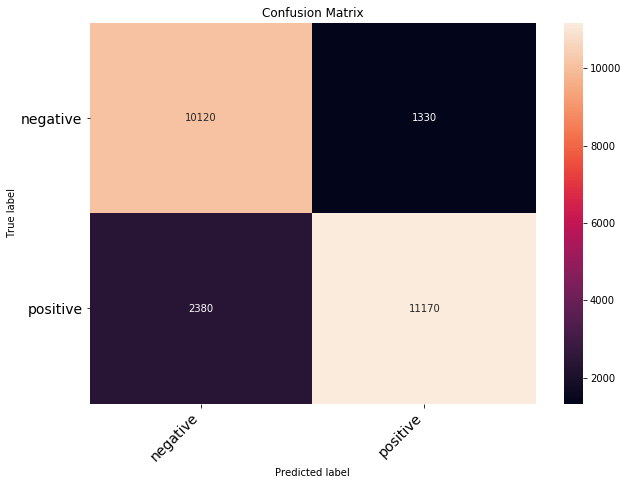

In [13]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix
cnf_matrix = confusion_matrix(pred, y_val)
_ = print_confusion_matrix(cnf_matrix, LABELS)

# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(pred, y_val, target_names=LABELS)
print(report)

## It's your turn

Test out the model you just trained. Edit the `my_review` variable and Run the Code cell below. Have fun!🎉

Here are some inspirations:
- Rian Johnson\'s Star Wars: The Last Jedi is a satisfying, at times transporting entertainment with visual wit and a distinctly human touch. 
- All evidence points to this animated film being contrived as a money-making scheme. The result is worse than crass, it\'s abominably bad.
- It was inevitable that there would be the odd turkey in there. What I didn\'t realise however, was that there could be one THIS bad.

And some wrong predictions:
- Pulp Fiction: Quentin Tarantino proves that he is the master of witty dialogue and a fast plot that doesn\'t allow the viewer a moment of boredom or rest.

Can you do better? Play around with the model hyperparameters!

In [14]:
from ipywidgets import interact_manual
from ipywidgets import widgets

def get_prediction(review):
    # Preprocessing
    review_np_array = imdb_tokenizer.texts_to_sequences([review])
    review_np_array = sequence.pad_sequences(review_np_array, maxlen=MAX_LEN, padding="post", value=0)
    # Prediction
    score = model.predict(review_np_array)[0][0]
    prediction = LABELS[model.predict_classes(review_np_array)[0][0]]
    print('REVIEW:', review, '\nPREDICTION:', prediction, '\nSCORE: ', score)

interact_manual(get_prediction, review=widgets.Textarea(placeholder='Type your Review here'));

interactive(children=(Textarea(value='', description='review', placeholder='Type your Review here'), Button(de…

## Save the result

In [12]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(imdb_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Model Weight
model.save_weights('models/cnn_sentiment_weights.h5')

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂